# DDoS Detection on CSE-CIC-IDS2018 AWS Dataset

This project aims to create a DDoS Detection Classifier trained on labelled network traffic data.

We start by importing a few libraries:

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.utils import class_weight

RANDOM_STATE_SEED = 12

ImportError: cannot import name 'plot_confusion_matrix' from 'sklearn.metrics' (d:\cicids\env-test\lib\site-packages\sklearn\metrics\__init__.py)

In [ ]:
# read the data
df_dataset = pd.read_csv("/kaggle/input/ids-intrusion-csv/02-14-2018.csv")

In [ ]:
# display data
df_dataset

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0,14/02/2018 08:31:01,112641719,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56320859.5,139.300036,56320958,56320761,Benign
1,0,0,14/02/2018 08:33:50,112641466,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56320733.0,114.551299,56320814,56320652,Benign
2,0,0,14/02/2018 08:36:39,112638623,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56319311.5,301.934596,56319525,56319098,Benign
3,22,6,14/02/2018 08:40:13,6453966,15,10,1239,2273,744,0,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
4,22,6,14/02/2018 08:40:23,8804066,14,11,1143,2209,744,0,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,80,6,14/02/2018 10:53:23,10156986,5,5,1089,1923,587,0,...,20,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
1048571,80,6,14/02/2018 10:53:33,117,2,0,0,0,0,0,...,20,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
1048572,80,6,14/02/2018 10:53:28,5095331,3,1,0,0,0,0,...,20,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
1048573,80,6,14/02/2018 10:53:28,5235511,3,1,0,0,0,0,...,20,0.0,0.0,0,0,0.0,0.000000,0,0,Benign


In [ ]:
# feature information
df_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 80 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Dst Port           1048575 non-null  int64  
 1   Protocol           1048575 non-null  int64  
 2   Timestamp          1048575 non-null  object 
 3   Flow Duration      1048575 non-null  int64  
 4   Tot Fwd Pkts       1048575 non-null  int64  
 5   Tot Bwd Pkts       1048575 non-null  int64  
 6   TotLen Fwd Pkts    1048575 non-null  int64  
 7   TotLen Bwd Pkts    1048575 non-null  int64  
 8   Fwd Pkt Len Max    1048575 non-null  int64  
 9   Fwd Pkt Len Min    1048575 non-null  int64  
 10  Fwd Pkt Len Mean   1048575 non-null  float64
 11  Fwd Pkt Len Std    1048575 non-null  float64
 12  Bwd Pkt Len Max    1048575 non-null  int64  
 13  Bwd Pkt Len Min    1048575 non-null  int64  
 14  Bwd Pkt Len Mean   1048575 non-null  float64
 15  Bwd Pkt Len Std    1048575 non-n

In [ ]:
# replace +ve and -ve infinity with NaN
df_dataset.replace([np.inf, -np.inf], np.nan, inplace=True)

In [ ]:
df_dataset.describe()

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,...,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,...,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06
mean,4.876262e+03,8.107557e+00,6.255555e+06,6.206622e+00,7.211191e+00,4.479936e+02,4.521803e+03,1.745736e+02,8.389535e+00,3.879579e+01,...,2.793536e+00,2.327970e+01,5.152449e+04,2.136151e+04,8.789157e+04,3.995477e+04,3.101206e+06,7.297218e+05,4.812391e+06,2.126920e+06
std,1.444344e+04,4.460625e+00,1.260291e+09,4.447851e+01,1.048682e+02,1.573541e+04,1.515021e+05,2.876713e+02,1.948279e+01,5.331882e+01,...,5.557106e+00,1.106185e+01,5.815586e+05,2.186405e+05,7.395725e+05,5.602693e+05,5.414780e+08,3.820031e+08,1.522117e+09,1.817013e+07
min,0.000000e+00,0.000000e+00,-9.190110e+11,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.200000e+01,6.000000e+00,7.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.300000e+01,6.000000e+00,1.023000e+03,2.000000e+00,1.000000e+00,3.600000e+01,5.500000e+01,3.400000e+01,0.000000e+00,2.566667e+01,...,0.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,4.430000e+02,6.000000e+00,4.066690e+05,7.000000e+00,6.000000e+00,4.550000e+02,7.680000e+02,1.990000e+02,0.000000e+00,5.550000e+01,...,4.000000e+00,3.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,6.553300e+04,1.700000e+01,1.200000e+08,5.115000e+03,9.198000e+03,8.591554e+06,1.339773e+07,6.444000e+04,1.460000e+03,1.121703e+04,...,1.031000e+03,4.800000e+01,1.102401e+08,5.723446e+07,1.102401e+08,1.102401e+08,3.394503e+11,2.432682e+11,9.797810e+11,1.260300e+10


In [ ]:
# drop missing values
df_dataset.dropna(inplace=True)

In [ ]:
df_dataset

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0,14/02/2018 08:31:01,112641719,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56320859.5,139.300036,56320958,56320761,Benign
1,0,0,14/02/2018 08:33:50,112641466,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56320733.0,114.551299,56320814,56320652,Benign
2,0,0,14/02/2018 08:36:39,112638623,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56319311.5,301.934596,56319525,56319098,Benign
3,22,6,14/02/2018 08:40:13,6453966,15,10,1239,2273,744,0,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
4,22,6,14/02/2018 08:40:23,8804066,14,11,1143,2209,744,0,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,80,6,14/02/2018 10:53:23,10156986,5,5,1089,1923,587,0,...,20,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
1048571,80,6,14/02/2018 10:53:33,117,2,0,0,0,0,0,...,20,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
1048572,80,6,14/02/2018 10:53:28,5095331,3,1,0,0,0,0,...,20,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
1048573,80,6,14/02/2018 10:53:28,5235511,3,1,0,0,0,0,...,20,0.0,0.0,0,0,0.0,0.000000,0,0,Benign


In [ ]:
df_dataset["Label"].value_counts()

Benign            663808
FTP-BruteForce    193354
SSH-Bruteforce    187589
Name: Label, dtype: int64

In [ ]:
df = df_dataset

We will now try to visualize the target feature's class distribution.

In [ ]:
from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py
import plotly.express as px
init_notebook_mode(connected=True)
import plotly.graph_objs as go

fig = go.Figure(data=[
    go.Bar(name='Benign', 
           y=df["Label"].value_counts().values[0:1],
           x=['Benign'],
           text = df["Label"].value_counts()[0:1],
           orientation='v',
           textposition='outside',),
    go.Bar(name='FTP-BruteForce', 
           y=df["Label"].value_counts().values[1:2],
           x=['FTP-BruteForce'],
           text = df["Label"].value_counts()[1:2],
           orientation='v',
           textposition='outside',),
    go.Bar(name='SSH-Bruteforce', 
           y=df["Label"].value_counts().values[2:],
           x=['SSH-Bruteforce'],
           text = df["Label"].value_counts()[2:],
           orientation='v',
           textposition='outside',)
])
# Change the bar mode
fig.update_layout(
                  width=800,
                  height=600,
                  title=f'Class Distribution',
                  yaxis_title='Number of attacks',
                  xaxis_title='Attack Name',)
iplot(fig)

As expected, most of the traffic is benign.

Since our goal is binary classification ("attack" vs "not attack"), we can group FTP and SSH brute force attacks under one name instead of keeping them separate. Let's name them "Malicious".

In [ ]:
df.replace(to_replace=["FTP-BruteForce", "SSH-Bruteforce"], value="Malicious", inplace=True)

In [ ]:
df_dataset["Label"].value_counts()

Benign       663808
Malicious    380943
Name: Label, dtype: int64

In [ ]:
fig = go.Figure(data=[
    go.Bar(name='Benign', 
           y=df["Label"].value_counts().values[0:1],
           x=['Benign'],
           text = df["Label"].value_counts()[0:1],
           orientation='v',
           textposition='outside',),
    go.Bar(name='Malicious', 
           y=df["Label"].value_counts().values[1:2],
           x=['Malicious'],
           text = df["Label"].value_counts()[1:2],
           orientation='v',
           textposition='outside',)
])
# Change the bar mode
fig.update_layout(
                  width=800,
                  height=600,
                  title=f'Class Distribution',
                  yaxis_title='Number of attacks',
                  xaxis_title='Attack Name',)
iplot(fig)

To prevent our classification model from being biased, we should make sure that the class distribution is even (i.e. 50% benign and 50% malicious).

Since there are 380493 instances of Malicious and 663808 instances of Benign, we can take 380493 instances of both Malicious and Benign to train our model with an even class distribution.

In [ ]:
df1 = df[df["Label"] == "Benign"][:380943]
df2 = df[df["Label"] == "Malicious"][:380943]
df_equal = pd.concat([ df1,df2], axis =0)

We now encode our class labels to integer values for the model to use.

In [ ]:
df_equal.replace(to_replace="Benign", value=0, inplace=True)
df_equal.replace(to_replace="Malicious", value=1, inplace=True)

We split the data into training and testing sets.

In [ ]:
train, test = train_test_split(df_equal, test_size=0.3, random_state=RANDOM_STATE_SEED)

In [ ]:
# display columns
train.columns

Index(['Dst Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Tot Fwd Pkts',
       'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
      

In [ ]:
# feature info
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533320 entries, 677869 to 92080
Data columns (total 80 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Dst Port           533320 non-null  int64  
 1   Protocol           533320 non-null  int64  
 2   Timestamp          533320 non-null  object 
 3   Flow Duration      533320 non-null  int64  
 4   Tot Fwd Pkts       533320 non-null  int64  
 5   Tot Bwd Pkts       533320 non-null  int64  
 6   TotLen Fwd Pkts    533320 non-null  int64  
 7   TotLen Bwd Pkts    533320 non-null  int64  
 8   Fwd Pkt Len Max    533320 non-null  int64  
 9   Fwd Pkt Len Min    533320 non-null  int64  
 10  Fwd Pkt Len Mean   533320 non-null  float64
 11  Fwd Pkt Len Std    533320 non-null  float64
 12  Bwd Pkt Len Max    533320 non-null  int64  
 13  Bwd Pkt Len Min    533320 non-null  int64  
 14  Bwd Pkt Len Mean   533320 non-null  float64
 15  Bwd Pkt Len Std    533320 non-null  float64
 16

All of our data except the 'Timestamp' column is numerical. These numerical columns contain different ranges of values, which can confuse our model.
Thus, we must normalize our data.

In [ ]:
min_max_scaler = MinMaxScaler().fit(train[['Flow Duration', 'Tot Fwd Pkts',
       'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
       'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Fwd Byts/b Avg',
       'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd Byts/b Avg',
       'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg', 'Subflow Fwd Pkts',
       'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts',
       'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts',
       'Fwd Seg Size Min', 'Active Mean', 'Active Std', 'Active Max',
       'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min']])

In [ ]:
numerical_columns = ['Flow Duration', 'Tot Fwd Pkts',
       'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
       'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Fwd Byts/b Avg',
       'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd Byts/b Avg',
       'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg', 'Subflow Fwd Pkts',
       'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts',
       'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts',
       'Fwd Seg Size Min', 'Active Mean', 'Active Std', 'Active Max',
       'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min']

In [ ]:
train[numerical_columns] = min_max_scaler.transform(train[numerical_columns])

In [ ]:
train

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
677869,53,17,14/02/2018 04:13:13,0.999869,0.000000,0.000111,0.000005,0.000008,0.000667,0.036565,...,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
429458,53,17,14/02/2018 08:45:12,0.999869,0.000000,0.000111,0.000006,0.000012,0.000791,0.043367,...,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
636880,49965,6,14/02/2018 09:21:42,0.999869,0.000204,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.416667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
760015,51970,6,14/02/2018 01:57:08,0.999869,0.000000,0.000111,0.000000,0.000000,0.000000,0.000000,...,0.416667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
362516,22,6,14/02/2018 03:19:01,0.999869,0.000000,0.000111,0.000000,0.000000,0.000000,0.000000,...,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183725,22,6,14/02/2018 02:05:58,0.999870,0.004279,0.002433,0.000234,0.000202,0.009932,0.000000,...,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
32083,21,6,14/02/2018 10:49:29,0.999869,0.000000,0.000111,0.000000,0.000000,0.000000,0.000000,...,0.833333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
637768,80,6,14/02/2018 10:49:13,0.999929,0.000204,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.416667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
380644,21,6,14/02/2018 12:10:06,0.999869,0.000000,0.000111,0.000000,0.000000,0.000000,0.000000,...,0.833333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [ ]:
train.describe()

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
count,533320.000000,533320.000000,533320.000000,533320.000000,533320.000000,5.333200e+05,533320.000000,533320.000000,533320.000000,533320.000000,...,533320.000000,533320.000000,533320.000000,533320.000000,533320.000000,533320.000000,533320.000000,533320.000000,533320.000000,533320.000000
mean,3626.720260,7.611832,0.999873,0.001052,0.000750,5.893228e-05,0.000252,0.002818,0.005449,0.003284,...,0.543590,0.000579,0.000295,0.000854,0.000449,0.000008,0.000004,0.000005,0.000133,0.500051
std,12468.804317,4.000155,0.001753,0.006889,0.009476,2.564790e-03,0.009352,0.004789,0.014728,0.004958,...,0.233554,0.006671,0.003658,0.007835,0.006333,0.001786,0.001748,0.001729,0.001754,0.500000
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,21.000000,6.000000,0.999869,0.000000,0.000111,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.416667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,22.000000,6.000000,0.999869,0.000000,0.000111,1.163934e-07,0.000000,0.000016,0.000000,0.000045,...,0.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,137.000000,6.000000,0.999870,0.001426,0.000774,6.774095e-05,0.000120,0.005307,0.000000,0.005745,...,0.833333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,65532.000000,17.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533320 entries, 677869 to 92080
Data columns (total 80 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Dst Port           533320 non-null  int64  
 1   Protocol           533320 non-null  int64  
 2   Timestamp          533320 non-null  object 
 3   Flow Duration      533320 non-null  float64
 4   Tot Fwd Pkts       533320 non-null  float64
 5   Tot Bwd Pkts       533320 non-null  float64
 6   TotLen Fwd Pkts    533320 non-null  float64
 7   TotLen Bwd Pkts    533320 non-null  float64
 8   Fwd Pkt Len Max    533320 non-null  float64
 9   Fwd Pkt Len Min    533320 non-null  float64
 10  Fwd Pkt Len Mean   533320 non-null  float64
 11  Fwd Pkt Len Std    533320 non-null  float64
 12  Bwd Pkt Len Max    533320 non-null  float64
 13  Bwd Pkt Len Min    533320 non-null  float64
 14  Bwd Pkt Len Mean   533320 non-null  float64
 15  Bwd Pkt Len Std    533320 non-null  float64
 16

In [ ]:
train.drop(['Timestamp'], axis=1,inplace=True)
test.drop(['Timestamp'],axis=1,inplace=True)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533320 entries, 677869 to 92080
Data columns (total 79 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Dst Port           533320 non-null  int64  
 1   Protocol           533320 non-null  int64  
 2   Flow Duration      533320 non-null  float64
 3   Tot Fwd Pkts       533320 non-null  float64
 4   Tot Bwd Pkts       533320 non-null  float64
 5   TotLen Fwd Pkts    533320 non-null  float64
 6   TotLen Bwd Pkts    533320 non-null  float64
 7   Fwd Pkt Len Max    533320 non-null  float64
 8   Fwd Pkt Len Min    533320 non-null  float64
 9   Fwd Pkt Len Mean   533320 non-null  float64
 10  Fwd Pkt Len Std    533320 non-null  float64
 11  Bwd Pkt Len Max    533320 non-null  float64
 12  Bwd Pkt Len Min    533320 non-null  float64
 13  Bwd Pkt Len Mean   533320 non-null  float64
 14  Bwd Pkt Len Std    533320 non-null  float64
 15  Flow Byts/s        533320 non-null  float64
 16

In [ ]:
test[numerical_columns] = min_max_scaler.transform(test[numerical_columns])

In [ ]:
test[numerical_columns]

,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,...,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
15923,0.999869,0.000000,0.000111,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.833333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
252010,0.999870,0.003871,0.002433,0.000226,0.000202,0.009932,0.00000,0.008665,0.008996,0.668493,...,0.015519,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
386370,0.999876,0.000611,0.000442,0.000011,0.000018,0.001505,0.00000,0.002162,0.003077,0.158904,...,0.000970,0.416667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
309066,0.999870,0.004279,0.002433,0.000223,0.000202,0.009932,0.00000,0.007748,0.008736,0.668493,...,0.015519,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
498655,0.999869,0.000000,0.000111,0.000003,0.000003,0.000466,0.02551,0.002675,0.000000,0.031507,...,0.000000,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
582416,0.999872,0.001019,0.000553,0.000053,0.000026,0.002173,0.00000,0.006761,0.003993,0.099315,...,0.003880,0.416667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
664673,0.999869,0.000407,0.000442,0.000017,0.000018,0.002297,0.00000,0.004398,0.005422,0.166438,...,0.000970,0.416667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
92708,0.999869,0.000000,0.000111,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.833333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
381015,0.999869,0.000000,0.000111,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.833333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
print("Full dataset:\n")
print("Benign: " + str(df_equal["Label"].value_counts()[[0]].sum()))
print("Malicious: " + str(df_equal["Label"].value_counts()[[1]].sum()))
print("---------------")

print("Training set:\n")
print("Benign: " + str(train["Label"].value_counts()[[0]].sum()))
print("Malicious: " + str(train["Label"].value_counts()[[1]].sum()))
print("---------------")

print("Test set:\n")
print("Benign: " + str(test["Label"].value_counts()[[0]].sum()))
print("Malicious: " + str(test["Label"].value_counts()[[1]].sum()))

Full dataset:

Benign: 380943
Malicious: 380943
---------------
Training set:

Benign: 266633
Malicious: 266687
---------------
Test set:

Benign: 114310
Malicious: 114256


In [ ]:
y_train = np.array(train.pop("Label"))# pop removes "Label" from the dataframe
#y_train = np.array(train.pop("Timestamp"))
X_train = train.values

print(type(X_train))
print(type(y_train))
print(X_train.shape)
print(y_train.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(533320, 78)
(533320,)


In [ ]:
y_test = np.array(test.pop("Label")) # pop removes "Label" from the dataframe
#y_test = np.array(test.pop("Timestamp"))
X_test = test.values

print(type(X_test))
print(type(y_test))
print(X_test.shape)
print(y_test.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(228566, 78)
(228566,)


In [ ]:
model = RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
    ccp_alpha=0.0,
    max_samples=None
)

hyperparameters = {
    'n_estimators': [50, 75, 100, 125, 150]
}

In [ ]:
clf = GridSearchCV(
    estimator=model,
    param_grid=hyperparameters,
    cv=5,
    verbose=1,
    n_jobs=-1  # Use all available CPU cores
)

In [ ]:
clf.fit(X=X_train, y=y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'n_estimators': [50, 75, 100, 125, 150]}, verbose=1)

In [ ]:
print("Accuracy score on Validation set: \n")
print(clf.best_score_ )
print("---------------")
print("Best performing hyperparameters on Validation set: ")
print(clf.best_params_)
print("---------------")
print(clf.best_estimator_)

Accuracy score on Validation set: 

0.9999981249531238
---------------
Best performing hyperparameters on Validation set: 
{'n_estimators': 50}
---------------
RandomForestClassifier(n_estimators=50)


In [ ]:
model = clf.best_estimator_

In [ ]:
model

RandomForestClassifier(n_estimators=50)

In [ ]:
predictions = model.predict(X_test)

In [ ]:
print(accuracy_score(y_test, predictions))

1.0


<AxesSubplot:>

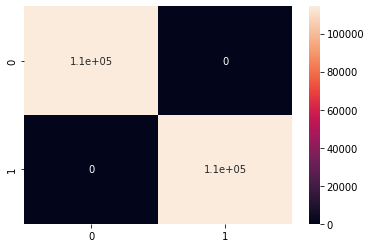

In [ ]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, predictions)
import seaborn as sns
sns.heatmap(cf_matrix, annot=True)

Let us also try making a Neural Network model using Keras.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
neuralNetModel = keras.Sequential([
    layers.InputLayer(input_shape=(78,)),
       
    layers.BatchNormalization(renorm=True),
    layers.Dense(128, activation='relu'),
    layers.Dropout(rate = 0.3),
    layers.BatchNormalization(renorm=True),
    layers.Dense(64, activation='relu'),
    layers.Dropout(rate = 0.3),
    layers.BatchNormalization(renorm=True),
    layers.Dense(32, activation='relu'),
    layers.Dropout(rate = 0.3),
    layers.Dense(1, activation='sigmoid'),
])

neuralNetModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 78)                546       
_________________________________________________________________
dense (Dense)                (None, 128)               10112     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               896       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                4

In [ ]:
optimizer = tf.keras.optimizers.Adam(epsilon=0.01)

from tensorflow.keras import callbacks

early_stopping = callbacks.EarlyStopping(
    min_delta = 0.001,
    patience = 5,
    restore_best_weights = True
)

neuralNetModel.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

history = neuralNetModel.fit(
    X_train, y_train,
    epochs=50,
    batch_size = 256,
    callbacks=[early_stopping]
)

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss']].plot()
history_frame.loc[:, ['binary_accuracy']].plot();

Epoch 1/50
2084/2084 [==============================] - 19s 8ms/step - loss: 0.3451 - binary_accuracy: 0.9590
Epoch 2/50
2084/2084 [==============================] - 16s 8ms/step - loss: 0.0043 - binary_accuracy: 0.9996
Epoch 3/50
2084/2084 [==============================] - 17s 8ms/step - loss: 0.0025 - binary_accuracy: 0.9997
Epoch 4/50
2084/2084 [==============================] - 17s 8ms/step - loss: 0.0018 - binary_accuracy: 0.9998
Epoch 5/50
2084/2084 [==============================] - 17s 8ms/step - loss: 0.0011 - binary_accuracy: 0.9999
Epoch 6/50
2084/2084 [==============================] - 16s 8ms/step - loss: 7.0085e-04 - binary_accuracy: 0.9999
Epoch 7/50
2084/2084 [==============================] - 17s 8ms/step - loss: 5.9567e-04 - binary_accuracy: 0.9999
Epoch 8/50
2084/2084 [==============================] - 16s 8ms/step - loss: 5.5016e-04 - binary_accuracy: 0.9999
Epoch 9/50
2084/2084 [==============================] - 17s 8ms/step - loss: 4.2672e-04 - binary_accuracy: 1

In [ ]:
predictions=(neuralNetModel.predict(X_test) > 0.5).astype("int32")


In [ ]:
print(accuracy_score(y_test, predictions))

In [ ]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, predictions)
import seaborn as sns
sns.heatmap(cf_matrix, annot=True)

Thus, this model gives us the same result as the Random Forest model.

While the models are accurate, it is worth noting that they work with labelled data. 

We should also try to come up with something for unlabelled data as the majority of recent data will be unlabelled. 
An Isolation Forest model can be used for this purpose, with our original data ratio where we had more Benign requests than Malicious ones.

In [ ]:
# value set to 1 and -1 as isolation forest assigns 1 to inliers and -1 to outliers
df.replace(to_replace="Benign", value=0, inplace=True)
df.replace(to_replace="Malicious", value=1, inplace=True)

We split the data into training and testing sets.

In [ ]:
train, test = train_test_split(df, test_size=0.3, random_state=RANDOM_STATE_SEED)

In [ ]:
# display columns
train.columns

In [ ]:
# feature info
train.info()

All of our data except the 'Timestamp' column is numerical. These numerical columns contain different ranges of values, which can confuse our model.
Thus, we must normalize our data.

In [ ]:
min_max_scaler = MinMaxScaler().fit(train[['Flow Duration', 'Tot Fwd Pkts',
       'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
       'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Fwd Byts/b Avg',
       'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd Byts/b Avg',
       'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg', 'Subflow Fwd Pkts',
       'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts',
       'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts',
       'Fwd Seg Size Min', 'Active Mean', 'Active Std', 'Active Max',
       'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min']])

In [ ]:
numerical_columns = ['Flow Duration', 'Tot Fwd Pkts',
       'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
       'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Fwd Byts/b Avg',
       'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd Byts/b Avg',
       'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg', 'Subflow Fwd Pkts',
       'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts',
       'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts',
       'Fwd Seg Size Min', 'Active Mean', 'Active Std', 'Active Max',
       'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min']

In [ ]:
train[numerical_columns] = min_max_scaler.transform(train[numerical_columns])

In [ ]:
train

In [ ]:
train.describe()

In [ ]:
train.info()

In [ ]:
train.drop(['Timestamp'], axis=1,inplace=True)
test.drop(['Timestamp'],axis=1,inplace=True)

In [ ]:
train.info()

In [ ]:
test[numerical_columns] = min_max_scaler.transform(test[numerical_columns])

In [ ]:
test[numerical_columns]

In [ ]:
test.describe()

In [ ]:
test.info()

In [ ]:
print("Full dataset:\n")
print("Benign: " + str(df["Label"].value_counts()[[0]].sum()))
print("Malicious: " + str(df["Label"].value_counts()[[1]].sum()))
print("---------------")

print("Training set:\n")
print("Benign: " + str(train["Label"].value_counts()[[0]].sum()))
print("Malicious: " + str(train["Label"].value_counts()[[1]].sum()))
print("---------------")

print("Test set:\n")
print("Benign: " + str(test["Label"].value_counts()[[0]].sum()))
print("Malicious: " + str(test["Label"].value_counts()[[1]].sum()))

In [ ]:
y_train = train.pop("Label")
X_train = train.values
y_test = test.pop("Label")
X_test = test.values


y_test

In [ ]:
y_train

We need to change the labels as an Isolation Forest will give us 1 for a Benign input (inlier) and a -1 for a Malicious input (outlier).

In [ ]:
def freq_count(data):
    mp = dict();
    for i in data:
        if i in mp:
            mp[i] = mp[i]+1
        else:
            mp[i] = 1
    return mp

y_train[y_train == 1] = -1
y_train[y_train == 0] = 1
print(freq_count(y_train))

y_test[y_test == 1] = -1
y_test[y_test == 0] = 1
freq_count(y_test)

In [ ]:
from sklearn.ensemble import IsolationForest
iFM = IsolationForest(
    n_estimators = 100,
    max_samples = "auto",
    random_state = 42,
    warm_start = False
)

In [ ]:
hyperparameters = {
    'n_estimators': [50, 75, 100, 125, 150]
}

isolationForestCV = GridSearchCV(
    estimator=iFM,
    scoring = 'accuracy',
    param_grid=hyperparameters,
    cv=5,
    verbose=1,
    n_jobs=-1  # Use all available CPU cores
)

In [ ]:
isolationForestCV.fit(X = X_train, y = y_train)

In [ ]:
print("Accuracy score on Validation set: \n")
print(isolationForestCV.best_score_ )
print("---------------")
print("Best performing hyperparameters on Validation set: ")
print(isolationForestCV.best_params_)
print("---------------")
print(isolationForestCV.best_estimator_)

In [ ]:
model = isolationForestCV.best_estimator_

In [ ]:
model

In [ ]:
predictions = model.predict(X_test)
freq_count(predictions)

In [ ]:
print(accuracy_score(y_test, predictions))

In [ ]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, predictions)
cf_matrix

In [ ]:
import seaborn as sns
sns.heatmap(cf_matrix, annot=True)